In [0]:
!pip install researchpy

In [0]:
import pandas as pd
import numpy as np 

import matplotlib as mp
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import seaborn as sns
sns.set(style="whitegrid")
sns.set(font_scale=2)

In [0]:
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery
client = bigquery.Client('thesisprojects2019')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Driving Distance - Test Statistic

ANOVA Test - Independent t-test.

Compare the means of the driving distancebetween all the different event. 

Can be compared to a regression model. 
outcome(i) = (model) + error(i)

### DRIVING DISTANCE --- Event Type & Stadium Location

In [0]:
# DRIVING DISTANCE
# create and import statistic table from bigquery

query = """ SELECT eventid, event_type, venue, event, driving_dist_km
                 FROM  `thesisprojects2019.audeMS.prediction_spectators_final`
                 WHERE postcode != 'undefined'
                 ORDER BY eventid, driving_dist_km """
data = client.query(query).to_dataframe()

In [0]:
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,eventid,event_type,venue,event,driving_dist_km,venue_eventtype
0,1_2017-11-04,Rugby International,twickenham,Barbarians New Zealand,0.498,Rugby International - twickenham
1,1_2017-11-04,Rugby International,twickenham,Barbarians New Zealand,0.810,Rugby International - twickenham


In [0]:
venue_eventtype_list = []
for i in data.venue_eventtype.unique():
  venue_eventtype_list.append(i)

In [0]:
data.groupby('venue_eventtype')['driving_dist_km'].mean()

venue_eventtype
Champions League - wembley stadium           60.279490
International Football - wembley stadium     62.092102
NFL - wembley stadium                       100.763269
Premier League - london stadium              49.902687
Premier League - vicarage road               45.919093
Premier League - wembley stadium             59.761084
Rugby International - twickenham             75.126446
Name: driving_dist_km, dtype: float64

#### Normal Distribution of the variable

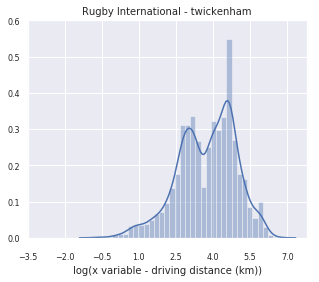

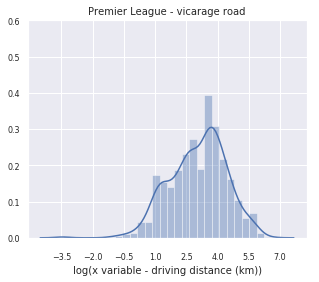

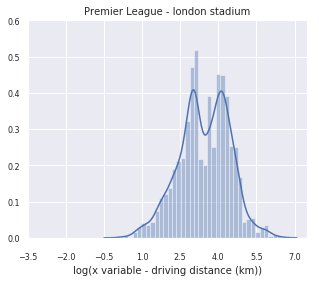

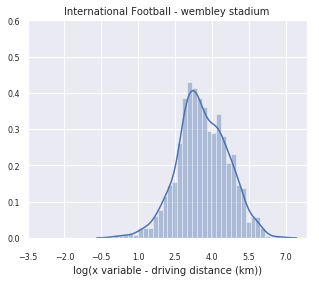

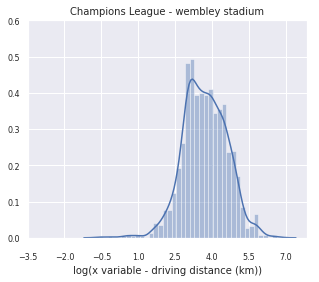

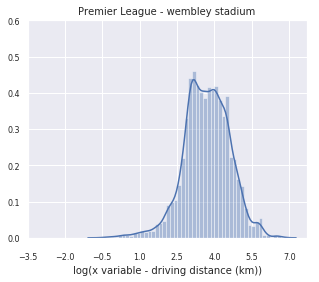

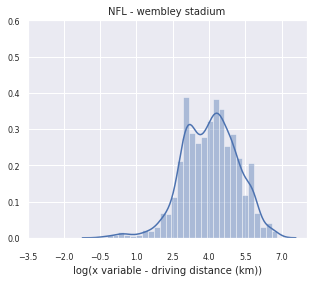

In [0]:
## For all different event
for i in venue_eventtype_list:
  
  new_data = data[data['venue_eventtype']==i].reset_index()
  eventname = new_data['venue_eventtype'][0]
  
  x = np.log(new_data['driving_dist_km'])
  
  f, ax = plt.subplots(figsize=(5,4))
  
  sns.distplot(x)
  
  plt.title(str(eventname), fontsize=10, horizontalalignment='center')
  plt.xlabel('log(x variable - driving distance (km))',fontsize='10', horizontalalignment='center')
  plt.xticks(horizontalalignment='center', fontsize='8')
  plt.yticks(horizontalalignment='center', fontsize='8') 
  ax.set_xticks(np.arange(-3.5,7.6,1.5))
  ax.set_yticks(np.arange(0,0.7,0.1))
  ax.tick_params(axis='both', which='major', pad=8)
  plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/Distance_Travel_Distribution/distplot_'+str(eventname)+'.png')
    
 # plt.close('all')
  plt.show()

In [0]:
import os
from google.colab import files

folderpath = '/content/drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/Distance_Travel_Distribution'

for filename in os.listdir(folderpath):
  #print(filename)
  files.download(folderpath+'/'+str(filename))

#### Summary Statistic of the data

In [0]:
# summary statistic of the data.
data['log_driving_dist_km'] = np.log(data['driving_dist_km'])
data.groupby(['venue_eventtype']).describe()

driving_dist_km  ... log_driving_dist_km
                                                   count  ...                 max
venue_eventtype                                           ...                    
Champions League - wembley stadium                2420.0  ...            6.807860
International Football - wembley stadium          2497.0  ...            6.763327
NFL - wembley stadium                             2300.0  ...            6.823341
Premier League - london stadium                   3830.0  ...            6.483379
Premier League - vicarage road                    1037.0  ...            6.584597
Premier League - wembley stadium                  9129.0  ...            6.812516
Rugby International - twickenham                  4136.0  ...            6.637327

[7 rows x 16 columns]



### TEST Statistical Assumption 
#### Levene Test - Homogeity of Variance



In [0]:
# Test for homgeity of variances
# Levene Test - If Test Significant : Homogeneity of variance is false

levene_test = []
event_list = []
for e in venue_eventtype_list:
  
  datanew = data[data['venue_eventtype']==e]
  data_nfl = data[data['venue_eventtype']=='Champions League - wembley stadium']
  
  test_levene = stats.levene(datanew['log_driving_dist_km'],data_nfl['log_driving_dist_km'])
  levene_test.append(test_levene)
  
  event_list.append(e)

In [0]:
# Test for homgeity of variances
# Levene Test - If Test Significant : Homogeneity of variance is false

new_df  =pd.DataFrame()

new_df['event'] = event_list
new_df['levene'] = levene_test

# Results -- p-value << 0.05 non-significant 
new_df

,event,levene
0,Rugby International - twickenham,"(221.60805900388826, 2.5615814619006147e-49)"
1,Premier League - vicarage road,"(261.3170758094444, 1.0156092018563169e-56)"
2,Premier League - london stadium,"(54.14180861290098, 2.1050055493079473e-13)"
3,International Football - wembley stadium,"(40.39629138258052, 2.2609036099531065e-10)"
4,Champions League - wembley stadium,"(0.0, 1.0)"
5,Premier League - wembley stadium,"(0.840502528959855, 0.3592722335959232)"
6,NFL - wembley stadium,"(112.42998246146489, 5.627318587656591e-26)"


#### Shapiro - Test for Normal Distribution

(The plot distribution from log transform variable, already show normal distribution!)

In [0]:
# Shapiro t-test
## Shapiro Test Positive (Significant) -- Non-Normaly Distributed Data
## Shapiro Test Negative (Non-Significant) -- Normaly Distributed Data 

shapiro_test = []
test_shapiro_pvalue_list = []
event_list = []
for e in venue_eventtype_list:
  
  datanew = data[data['venue_eventtype']==e]
  
  test_shapiro = stats.shapiro(datanew['log_driving_dist_km'])[0]
  test_shapiro_pvalue = stats.shapiro(datanew['log_driving_dist_km'])[1]
  shapiro_test.append(test_shapiro)
  test_shapiro_pvalue_list.append(test_shapiro_pvalue)
  
  event_list.append(e)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [0]:
# Shapiro Test
# Test assumption of normality. (First value w-test stat, Second value p-value)

new_df  =pd.DataFrame()

new_df['Event Category'] = event_list
new_df['Shapiro test'] = shapiro_test
new_df['p-value'] = test_shapiro_pvalue_list

# Result - p-value << 0.05 True 
new_df

,Event Category,Shapiro test,p-value
0,Rugby International - twickenham,0.981400,6.739313e-23
1,Premier League - vicarage road,0.984801,6.434790e-09
2,Premier League - london stadium,0.992426,2.231752e-13
3,International Football - wembley stadium,0.996761,3.632619e-05
4,Champions League - wembley stadium,0.990108,7.384706e-12
5,Premier League - wembley stadium,0.988829,3.467346e-26
6,NFL - wembley stadium,0.988488,1.210463e-12


### ANOVA Test

In [0]:
# ANOVA Independent t-test

test = stats.f_oneway(data['log_driving_dist_km'][data['venue_eventtype'] == 'Rugby International - twickenham'],
               data['log_driving_dist_km'][data['venue_eventtype'] == 'Premier League - wembley stadium'],
               data['log_driving_dist_km'][data['venue_eventtype'] == 'Premier League - vicarage road'],
               data['log_driving_dist_km'][data['venue_eventtype'] == 'Premier League - london stadium'],
               data['log_driving_dist_km'][data['venue_eventtype'] == 'NFL - wembley stadium'],
               data['log_driving_dist_km'][data['venue_eventtype'] == 'International Football - wembley stadium'],
               data['log_driving_dist_km'][data['venue_eventtype'] == 'Champions League - wembley stadium'])

print(test)
## p-value significant << 0.05
## F-statistic significant large!

F_onewayResult(statistic=148.9550110203678, pvalue=1.7538221520489175e-186)


In [0]:
results = ols('log_driving_dist_km ~ C(venue_eventtype)', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_driving_dist_km   R-squared:                       0.034
Model:                             OLS   Adj. R-squared:                  0.034
Method:                  Least Squares   F-statistic:                     149.0
Date:                 Sat, 24 Aug 2019   Prob (F-statistic):          1.75e-186
Time:                         12:09:18   Log-Likelihood:                -36555.
No. Observations:                25349   AIC:                         7.312e+04
Df Residuals:                    25342   BIC:                         7.318e+04
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          3.7083      0.021    178.232      0.000       3.668       3.749
C(venue_eventtype)[T.International Football - wembley stadium]    -0.0863      0.029     -2.957      0.003      -0.144      -0.029
C(venue_eventtype)[T.NFL - wembley stadium]                        0.3342      0.030     11.211      0.000       0.276       0.393
C(venue_eventtype)[T.Premier League - london stadium]             -0.2586      0.027     -9.731      0.000      -0.311      -0.207
C(venue_eventtype)[T.Premier League - vicarage road]              -0.6553      0.038    -17.251      0.000      -0.730      -0.581
C(venue_eventtype)[T.Premier League - wembley stadium]            -0.0209      0.023     -0.893      0.372      -0.067       0.025
C(venue_eventtype)[T.Rugby International - twickenham]             0.0402      0.026      1.535      0.125      -0.011       0.092
==============================================================================
Omnibus:                      605.949   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.875
Skew:                          -0.317   Prob(JB):                    1.79e-162
Kurtosis:                       3.551   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
## Bonferroni Correction
## Calculate the corrected p-value 
## corrected p-value = p-value/# of comparisons = 0.05/(7 event_type)
print('Corrected p-value: '+str(0.05/7))

Corrected p-value: 0.0071428571428571435


#### Degree of Freedom

In [0]:
# Report the Degrees of Freedom. 

def ttest_twosamples(x, y): 
    ## T-Test Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    ttest_twosample = round(t,4)
    p_value = round(p,8)
    degfree = round(dof,4)
    
    return ttest_twosample, p_value, degfree

#### Independent T-test

In [0]:
ttest_twosamples_list = []
p_value_list = []
degfree_list = []
event1_list = []
event2_list= []

for e in venue_eventtype_list:
  
#  print(' NFL v. '+str(e))
  nfl_welch_ttest = ttest_twosamples(data['log_driving_dist_km'][data['venue_eventtype'] == e], 
                                            data['log_driving_dist_km'][data['venue_eventtype'] == 'NFL - wembley stadium'])
 # print(nfl_welch_ttest[])
  
  ttest_twosamples_list.append(nfl_welch_ttest[0])
  p_value_list.append(nfl_welch_ttest[1])
  degfree_list.append(nfl_welch_ttest[2])
  
  event1_list.append('NFL - Wembley')
  event2_list.append(e)
  
  
#  print(' Champions League v. '+str(e))
  chs_welch_ttest = ttest_twosamples(data['log_driving_dist_km'][data['venue_eventtype'] == e], 
                                            data['log_driving_dist_km'][data['venue_eventtype'] == 'Champions League - wembley stadium'])

  ttest_twosamples_list.append(chs_welch_ttest[0])
  p_value_list.append(chs_welch_ttest[1])
  degfree_list.append(chs_welch_ttest[2])
  
  event1_list.append('Champions League - wembley')
  event2_list.append(e)
  
 # print(' International Football WCQ v. '+str(e))
  if_welch_ttest = ttest_twosamples(data['log_driving_dist_km'][data['venue_eventtype'] == e], 
                                            data['log_driving_dist_km'][data['venue_eventtype'] == 'International Football - wembley stadium'])

  ttest_twosamples_list.append(if_welch_ttest[0])
  p_value_list.append(if_welch_ttest[1])
  degfree_list.append(if_welch_ttest[2])
  
  event1_list.append('International Football WCQ - wembley')
  event2_list.append(e)
  
 # print(' Rugby v. '+str(e))
  rugby_welch_ttest = ttest_twosamples(data['log_driving_dist_km'][data['venue_eventtype'] == e], 
                                            data['log_driving_dist_km'][data['venue_eventtype'] == 'Rugby International - twickenham'])

  ttest_twosamples_list.append(rugby_welch_ttest[0])
  p_value_list.append(rugby_welch_ttest[1])
  degfree_list.append(rugby_welch_ttest[2])
  
  event1_list.append('Rugby - twickenham')
  event2_list.append(e)
  
 # print(' Watford v. '+str(e))
  plwa_welch_ttest = ttest_twosamples(data['log_driving_dist_km'][data['venue_eventtype'] == e], 
                                            data['log_driving_dist_km'][data['venue_eventtype'] == 'Premier League - vicarage road'])
  
  ttest_twosamples_list.append(plwa_welch_ttest[0])
  p_value_list.append(plwa_welch_ttest[1])
  degfree_list.append(plwa_welch_ttest[2])
  
  event1_list.append('Premier League - watford')
  event2_list.append(e)
  
#  print(' Wembley v. '+str(e))
  plwe_welch_ttest = ttest_twosamples(data['log_driving_dist_km'][data['venue_eventtype'] == e], 
                                            data['log_driving_dist_km'][data['venue_eventtype'] == 'Premier League - wembley stadium'])

  ttest_twosamples_list.append(plwe_welch_ttest[0])
  p_value_list.append(plwe_welch_ttest[1])
  degfree_list.append(plwe_welch_ttest[2])
  
  event1_list.append('Premier League - wembley')
  event2_list.append(e)
  
 # print(' London Stadium v. '+str(e)) 
  plls_welch_ttest = ttest_twosamples(data['log_driving_dist_km'][data['venue_eventtype'] == e], 
                                            data['log_driving_dist_km'][data['venue_eventtype'] == 'Premier League - london stadium'])
  
  ttest_twosamples_list.append(plls_welch_ttest[0])
  p_value_list.append(plls_welch_ttest[1])
  degfree_list.append(plls_welch_ttest[2])
  
  event1_list.append('Premier League - london stadium')
  event2_list.append(e)

In [0]:
ttest_twosamples_df = pd.DataFrame(list(zip(event2_list, event1_list,ttest_twosamples_list,p_value_list,degfree_list)), 
               columns =['Event Category 1', 'Event Category 2',"Independent t-test",'p-value','Degree of Freedom']) 

ttest_twosamples_df = ttest_twosamples_df[ttest_twosamples_df['p-value']!=1.0]
ttest_twosamples_df = ttest_twosamples_df.drop_duplicates(['p-value','Degree of Freedom']).reset_index(drop=True)

In [0]:
ttest_twosamples_df

,Event Category 1,Event Category 2,Independent t-test,p-value,Degree of Freedom
0,Rugby International - twickenham,NFL - Wembley,-9.9072,0.000000,4915.3573
1,Rugby International - twickenham,Champions League - wembley,1.5633,0.118028,6110.3424
2,Rugby International - twickenham,International Football WCQ - wembley,4.6233,0.000004,5815.9603
4,Rugby International - twickenham,Premier League - watford,15.1924,0.000000,1448.6942
5,Rugby International - twickenham,Premier League - wembley,2.9659,0.003029,6550.5344
6,Rugby International - twickenham,Premier League - london stadium,12.3059,0.000000,7906.6845
7,Premier League - vicarage road,NFL - Wembley,-20.5709,0.000000,1706.5127
8,Premier League - vicarage road,Champions League - wembley,-14.3182,0.000000,1438.3007
9,Premier League - vicarage road,International Football WCQ - wembley,-12.1794,0.000000,1548.6699
10,Premier League - vicarage road,Rugby - twickenham,-15.1924,0.000000,1448.6942


# ACORN - Test Statistic



## ACORN Category

### Chi-Squared Test

In [0]:
#import statistic table from bigquery
query = """ SELECT  b.venue, b.event_type, b.acorn_category
                 FROM `thesisprojects2019.audeMS.prediction_spectators_final` as b
                 WHERE acorn_category != -1
                 ORDER BY acorn_category, event_type, venue  """
data = client.query(query).to_dataframe()

In [0]:
data['acorn_category']=data['acorn_category'].astype(str)
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,venue,event_type,acorn_category,venue_eventtype
0,wembley stadium,Champions League,1.0,Champions League - wembley stadium
1,wembley stadium,Champions League,1.0,Champions League - wembley stadium


In [0]:
# create contingency table pandas
contingency_df = pd.crosstab(data['venue_eventtype'],data['acorn_category'])
observed = contingency_df
contingency_df

acorn_category,1.0,2.0,3.0,4.0,5.0,6.0
venue_eventtype,,,,,,
Champions League - wembley stadium,728,611,477,250,280,74
International Football - wembley stadium,544,675,483,291,370,134
NFL - wembley stadium,549,622,513,267,260,89
Premier League - london stadium,944,939,905,452,448,142
Premier League - vicarage road,349,232,218,126,81,31
Premier League - wembley stadium,2567,2220,1995,1034,1047,266
Rugby International - twickenham,1489,1360,609,268,266,144


In [0]:
# sum the values of the rows
contingency_df['row_sum'] = contingency_df.sum(axis=1)
# sum the values of the columns
column_sum = pd.Series(contingency_df.sum(axis=0),name='column_sum')
contingency_df = contingency_df.append(column_sum)
contingency_df

acorn_category,1.0,2.0,3.0,4.0,5.0,6.0,row_sum
venue_eventtype,,,,,,,
Champions League - wembley stadium,728,611,477,250,280,74,2420
International Football - wembley stadium,544,675,483,291,370,134,2497
NFL - wembley stadium,549,622,513,267,260,89,2300
Premier League - london stadium,944,939,905,452,448,142,3830
Premier League - vicarage road,349,232,218,126,81,31,1037
Premier League - wembley stadium,2567,2220,1995,1034,1047,266,9129
Rugby International - twickenham,1489,1360,609,268,266,144,4136
column_sum,7170,6659,5200,2688,2752,880,25349


In [0]:
## Calculate the expected value
expected =  np.outer(contingency_df['row_sum'][0:7],
                     contingency_df.loc['column_sum'][0:6]) / 25349

expected = pd.DataFrame(expected)

expected.columns = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
expected.index = ['Champions League - wembley stadium',
       'International Football - wembley stadium', 'NFL - wembley stadium',
       'Premier League - london stadium', 'Premier League - vicarage road',
       'Premier League - wembley stadium', 'Rugby International - twickenham']

expected

,1.0,2.0,3.0,4.0,5.0,6.0
Champions League - wembley stadium,684.500375,635.716596,496.429839,256.616040,262.725946,84.011204
International Football - wembley stadium,706.279932,655.943943,512.225334,264.781096,271.085408,86.684287
NFL - wembley stadium,650.558207,604.193459,471.813484,243.891278,249.698213,79.845359
Premier League - london stadium,1083.320841,1006.113456,785.672019,406.131997,415.801807,132.959880
Premier League - vicarage road,293.316896,272.412442,212.726340,109.963154,112.581325,35.999842
Premier League - wembley stadium,2582.150381,2398.122648,1872.689258,968.036293,991.084777,316.916644
Rugby International - twickenham,1169.873368,1086.497456,848.443726,438.580141,449.022526,143.582784


In [0]:
# Calculate the Chi-Square Statistic
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

613.6026643116771


In [0]:
crit = stats.chi2.ppf(q = 0.99, # Find the critical value for 95% confidence*
                      df = 30)   # Degree of Freedom? Table 7x6 -- df = 6x5 = 30

print("Critical value")
print(crit)
print('')

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=30)
print("P value")
print(p_value)


Critical value
50.89218131151707

P value
0.0


In [0]:
stats.chi2_contingency(observed= observed)

## p-value is really little !! This mean that there is a significatn relations between the variables
## ACORN category are not random !

(613.6026643116771,
 3.2214291553631976e-106,
 36,
 array([[ 684.50037477,  635.71659632,  496.42983944,  256.61604008,
          262.7259458 ,   84.0112036 , 2420.        ],
        [ 706.27993215,  655.94394256,  512.22533433,  264.7810959 ,
          271.08540771,   86.68428735, 2497.        ],
        [ 650.55820742,  604.19345931,  471.81348377,  243.89127776,
          249.69821295,   79.84535879, 2300.        ],
        [1083.32084106, 1006.11345615,  785.67201862,  406.13199732,
          415.80180678,  132.95988007, 3830.        ],
        [ 293.31689613,  272.41244231,  212.72634029,  109.96315437,
          112.58132471,   35.9998422 , 1037.        ],
        [2582.15038069, 2398.12264784, 1872.68925796,  968.03629334,
          991.08477652,  316.91664365, 9129.        ],
        [1169.87336779, 1086.49745552,  848.44372559,  438.58014123,
          449.02252554,  143.58278433, 4136.        ]]))

## ACORN Group

### Chi-Squared Test

In [0]:
#import statistic table from bigquery
query = """ SELECT  b.venue, b.event_type, b.acorn_group
                 FROM `thesisprojects2019.audeMS.prediction_spectators_final` as b
                 WHERE acorn_group != 'undefined'
                 ORDER BY acorn_group, event_type, venue  """
data = client.query(query).to_dataframe()

In [0]:
data['acorn_group']=data['acorn_group'].astype(str)
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,venue,event_type,acorn_group,venue_eventtype
0,wembley stadium,Champions League,A,Champions League - wembley stadium
1,wembley stadium,Champions League,A,Champions League - wembley stadium


In [0]:
# create contingency table pandas
contingency_df = pd.crosstab(data['venue_eventtype'],data['acorn_group'])
observed = contingency_df
contingency_df

acorn_group,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R
venue_eventtype,,,,,,,,,,,,,,,,,,
Champions League - wembley stadium,88,440,200,278,333,31,149,199,16,82,85,50,95,20,67,173,40,74
International Football - wembley stadium,69,324,151,343,332,27,158,176,11,111,107,66,94,24,57,257,56,134
NFL - wembley stadium,31,348,170,283,339,42,141,190,23,117,88,83,79,17,76,146,38,89
Premier League - london stadium,117,568,259,379,560,54,235,407,66,143,117,136,164,35,90,305,53,142
Premier League - vicarage road,50,228,71,79,153,9,81,59,1,68,23,29,63,11,14,37,30,31
Premier League - wembley stadium,325,1524,718,980,1240,104,575,889,61,366,303,237,384,110,246,662,139,266
Rugby International - twickenham,260,899,330,848,512,83,173,199,21,133,103,64,77,24,47,194,25,144


In [0]:
# sum the values of the rows
contingency_df['row_sum'] = contingency_df.sum(axis=1)
# sum the values of the columns
column_sum = pd.Series(contingency_df.sum(axis=0),name='column_sum')
contingency_df = contingency_df.append(column_sum)
contingency_df

acorn_group,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,row_sum
venue_eventtype,,,,,,,,,,,,,,,,,,,
Champions League - wembley stadium,88,440,200,278,333,31,149,199,16,82,85,50,95,20,67,173,40,74,2420
International Football - wembley stadium,69,324,151,343,332,27,158,176,11,111,107,66,94,24,57,257,56,134,2497
NFL - wembley stadium,31,348,170,283,339,42,141,190,23,117,88,83,79,17,76,146,38,89,2300
Premier League - london stadium,117,568,259,379,560,54,235,407,66,143,117,136,164,35,90,305,53,142,3830
Premier League - vicarage road,50,228,71,79,153,9,81,59,1,68,23,29,63,11,14,37,30,31,1037
Premier League - wembley stadium,325,1524,718,980,1240,104,575,889,61,366,303,237,384,110,246,662,139,266,9129
Rugby International - twickenham,260,899,330,848,512,83,173,199,21,133,103,64,77,24,47,194,25,144,4136
column_sum,940,4331,1899,3190,3469,350,1512,2119,199,1020,826,665,956,241,597,1774,381,880,25349


In [0]:
contingency_df.shape

(8, 19)

In [0]:
## Calculate the expected value
expected =  np.outer(contingency_df['row_sum'][0:7],
                     contingency_df.loc['column_sum'][0:18]) / 25349

expected = pd.DataFrame(expected)

expected.columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R']
expected.index = ['Champions League - wembley stadium',
       'International Football - wembley stadium', 'NFL - wembley stadium',
       'Premier League - london stadium', 'Premier League - vicarage road',
       'Premier League - wembley stadium', 'Rugby International - twickenham']

expected

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R
Champions League - wembley stadium,89.739240,413.468776,181.292359,304.540613,331.175983,33.413547,144.346523,202.295160,18.997988,97.376622,78.855971,63.485739,91.266717,23.007614,56.993964,169.358949,36.373032,84.011204
International Football - wembley stadium,92.594580,426.624601,187.060752,314.230542,341.713401,34.476705,148.939366,208.731824,19.602470,100.474969,81.365024,65.505740,94.170658,23.739674,58.807409,174.747643,37.530356,86.684287
NFL - wembley stadium,85.289361,392.966192,172.302655,289.439426,314.754034,31.756677,137.188844,192.263995,18.055939,92.548030,74.945757,60.337686,86.741094,21.866740,54.167817,160.960985,34.569411,79.845359
Premier League - london stadium,142.025326,654.374137,286.921378,481.979565,524.133891,52.881770,228.449248,320.161348,30.067064,154.112588,124.800978,100.475364,144.442779,36.412876,90.201191,268.035031,57.565584,132.959880
Premier League - vicarage road,38.454377,177.176496,77.686023,130.499428,141.913014,14.318119,61.854274,86.685984,8.140873,41.727090,33.790761,27.204426,39.108919,9.859048,24.422620,72.572409,15.586295,35.999842
Premier League - wembley stadium,338.524597,1559.734072,683.891712,1148.822833,1249.299815,126.046392,544.520415,763.120873,71.666377,367.335201,297.469486,239.488145,344.286717,86.791944,214.999132,638.875143,137.210501,316.916644
Rugby International - twickenham,153.372520,706.655726,309.845122,520.487593,566.009862,57.106789,246.701329,345.740818,32.469289,166.425500,134.772023,108.502900,155.983116,39.322103,97.407866,289.449840,62.164819,143.582784


In [0]:
# Calculate the Chi-Square Statistic
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

1171.683906722485


In [0]:
crit = stats.chi2.ppf(q = 0.99, # Find the critical value for 95% confidence*
                      df = 102)   # Degree of Freedom? Table 7x18 -- df = 6x17 = 102

print("Critical value")
print(crit)
print('')

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=102)
print("P value")
print(p_value)


Critical value
138.13447114967263

P value
0.0


In [0]:
stats.chi2_contingency(observed=observed)

## p-value is really little !! This mean that there is a significatn relations between the variables
## ACORN category are not random !

(1171.6839067224855,
 4.7273125813344627e-178,
 108,
 array([[8.97392402e+01, 4.13468776e+02, 1.81292359e+02, 3.04540613e+02,
         3.31175983e+02, 3.34135469e+01, 1.44346523e+02, 2.02295160e+02,
         1.89979881e+01, 9.73766224e+01, 7.88559706e+01, 6.34857391e+01,
         9.12667166e+01, 2.30076137e+01, 5.69939643e+01, 1.69358949e+02,
         3.63730325e+01, 8.40112036e+01, 2.42000000e+03],
        [9.25945797e+01, 4.26624601e+02, 1.87060752e+02, 3.14230542e+02,
         3.41713401e+02, 3.44767052e+01, 1.48939366e+02, 2.08731824e+02,
         1.96024695e+01, 1.00474969e+02, 8.13650243e+01, 6.55057399e+01,
         9.41706576e+01, 2.37396741e+01, 5.88074086e+01, 1.74747643e+02,
         3.75303562e+01, 8.66842873e+01, 2.49700000e+03],
        [8.52893605e+01, 3.92966192e+02, 1.72302655e+02, 2.89439426e+02,
         3.14754034e+02, 3.17566768e+01, 1.37188844e+02, 1.92263995e+02,
         1.80559391e+01, 9.25480295e+01, 7.49457572e+01, 6.03376859e+01,
         8.67410943e+01, 2.1